# 1. 없다면 어떻게 될까? (ResNet Ablation Study)

## 프로젝트: ResNet Ablation Study

### 0) CIFAR-10 데이터셋 준비
---

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.
ds_train,ds_info = tfds.load('cats_vs_dogs',split= 'train', with_info=True)
ds_train = tfds.load('cats_vs_dogs',split= 'train[:80%]',as_supervised=True)
ds_test =  tfds.load('cats_vs_dogs',split= 'train[80%:]',as_supervised=True)

In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [7]:
def normalize_and_resize_img(data,y):
    """Normalizes images: `uint8` -> `float32`."""
    # x = data['image']
    # y = data['label']
    data = tf.cast(data,tf.float32)/255.
    image = tf.image.resize(data, [224, 224])
    return image, y

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img,num_parallel_calls=1).batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_info.features["label"].num_classes

2

In [10]:
ds_info.features["label"].names

['cat', 'dog']

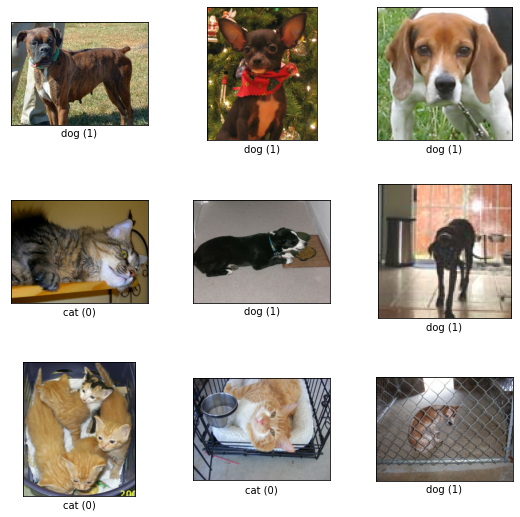

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

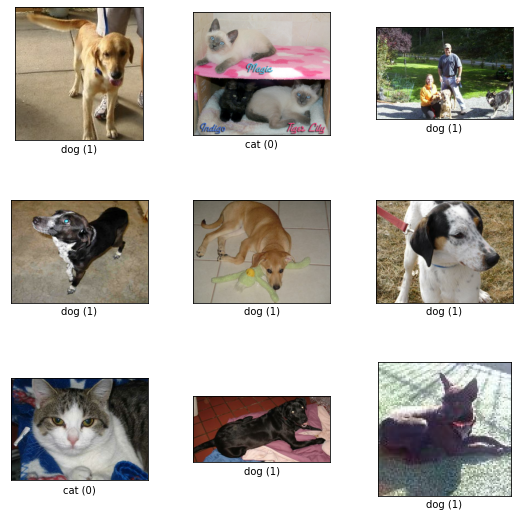

In [12]:
fig = tfds.show_examples(ds_test, ds_info)

In [13]:
ds_train = apply_normalize_on_dataset(ds_train,batch_size=16)
ds_test = apply_normalize_on_dataset(ds_test,batch_size=16)

In [14]:
ds_test

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

### 1) ResNet 기본 블록 구성하기
---
이제 실전으로 돌아와서 __ResNet-34__와 __ResNet-50__ 네트워크를 직접 만든다고 생각해보자. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아보자.

[Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)

<img src="./image/resnet.png" />

__ResNet 34와 50에서 사용된 블록들의 공통점과 차이점__

* ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있다. 
* 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다르다. 
* ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, 
* ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 된다.

이번에는 ResNet의 블록을 직접 만들어보자. 혹시나 모델 내의 앞과 뒤에서 반복되지 않을 것 같은 부분은 함수로 구현하지 않아도 된다.

우리가 지금 만들어야 하는 것은 블록을 생성하는 함수이다.<br>
일단은 VGG에서도 블록을 생성하는 함수를 만들었다. ResNet이라 하더라도 아이디어의 기본 원리는 다르지 않다.

그리고, 아마 이전에 VGG-16이나 ResNet-50 모델을 만들어서 훈련까지 시켜본 경험이 있을 것이다. 코드를 스스로 구현한 것이 아니라 공개된 오픈소스를 활용해서 빠르게 구성했겠지만, 블록 생성 함수가 어떤 형태로 만들어지는지를 이미 경험했을 테니 그것을 참고하는 것이 도움이 될 것이다.

하지만 이번 단계에서는 가급적 ResNet 논문을 통해서 구현방법에 대한 정보를 얻기를 권한다. 논문만 보고 스스로 구현해 보는 경험을 통해 딥러닝 개발자로서의 내공과 자신감이 다져지게 될 것이다.

#### ResNet 34

In [15]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, AveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Flatten
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math


input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')

 
def conv1_layer(x):
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), 2)(x)  
 
    return x
 
def conv2_layer(x):         

    shortcut = x
    
    for i in range(3):
        
        if(i == 0):            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            
            x = Add()([x, shortcut])
            
            x = Activation('relu')(x)
        
            shortcut = x
            
        else:
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            
            x = Activation('relu')(x)
            
            shortcut = x

    return x
 
def conv3_layer(x):
    
    shortcut = x
    
    for i in range(4):
        
        if(i == 0):            
            x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)  
        
            shortcut = x
        
        else:
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
    return x
 
 
 
def conv4_layer(x):
    
    shortcut = x

    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
        
            shortcut = x
        
        else:
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Add()([x, shortcut])
            x = Activation('relu')(x)

    return x
 
 
 
def conv5_layer(x):
    
    shortcut = x

    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
        
            shortcut = x
    
        else:
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Add()([x, shortcut])
            x = Activation('relu')(x)          
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = AveragePooling2D(pool_size=(1,1))(x)
x = Flatten()(x)
output_tensor = Dense(10, activation='softmax')(x)
 
resnet34 = Model(input_tensor, output_tensor)
resnet34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### ResNet 50

* [구조는 여기](https://ropiens.tistory.com/32), [코드는 여기](https://sike6054.github.io/blog/paper/first-post/)를 참고했다.

In [16]:
input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')

 
def conv1_layer(x):
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), 2)(x)  
 
    return x
 
def conv2_layer(x):         
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x
    
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = AveragePooling2D(pool_size=(1,1))(x)
x = Flatten()(x)

output_tensor = Dense(10, activation='softmax')(x)

resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

### 2) ResNet-34, ResNet-50 Complete Model

#### ResNet-34
VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어보자. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 `build_resnet()`를 통해서 ResNet의 여러가지 버전들을 모두 만들어 낼 수 있도록 해야 한다.

다음의 코드를 실행하면,

```bash
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()
```

<details>
<summary>실행 결과</summary>
<div markdown="1">       

```python
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 16, 16, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_568 (Activation)     (None, 16, 16, 64)   0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
stage2_0_maxpooling (MaxPooling (None, 8, 8, 64)     0           activation_568[0][0]             
__________________________________________________________________________________________________
stage2_1_conv1 (Conv2D)         (None, 8, 8, 64)     36928       stage2_0_maxpooling[0][0]        
__________________________________________________________________________________________________
stage2_1_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_569 (Activation)     (None, 8, 8, 64)     0           stage2_1_bn1[0][0]               
__________________________________________________________________________________________________
stage2_1_conv2 (Conv2D)         (None, 8, 8, 64)     36928       activation_569[0][0]             
__________________________________________________________________________________________________
stage2_1_bn2 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_1_conv2[0][0]             
__________________________________________________________________________________________________
stage2_1_add (Add)              (None, 8, 8, 64)     0           stage2_1_bn2[0][0]               
                                                                 stage2_0_maxpooling[0][0]        
__________________________________________________________________________________________________
activation_570 (Activation)     (None, 8, 8, 64)     0           stage2_1_add[0][0]               
__________________________________________________________________________________________________
stage2_2_conv1 (Conv2D)         (None, 8, 8, 64)     36928       activation_570[0][0]             
__________________________________________________________________________________________________
stage2_2_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_571 (Activation)     (None, 8, 8, 64)     0           stage2_2_bn1[0][0]               
__________________________________________________________________________________________________
stage2_2_conv2 (Conv2D)         (None, 8, 8, 64)     36928       activation_571[0][0]             
__________________________________________________________________________________________________
stage2_2_bn2 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_2_conv2[0][0]             
__________________________________________________________________________________________________
stage2_2_add (Add)              (None, 8, 8, 64)     0           stage2_2_bn2[0][0]               
                                                                 activation_570[0][0]             
__________________________________________________________________________________________________
activation_572 (Activation)     (None, 8, 8, 64)     0           stage2_2_add[0][0]               
__________________________________________________________________________________________________
stage2_3_conv1 (Conv2D)         (None, 8, 8, 64)     36928       activation_572[0][0]             
__________________________________________________________________________________________________
stage2_3_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_573 (Activation)     (None, 8, 8, 64)     0           stage2_3_bn1[0][0]               
__________________________________________________________________________________________________
stage2_3_conv2 (Conv2D)         (None, 8, 8, 64)     36928       activation_573[0][0]             
__________________________________________________________________________________________________
stage2_3_bn2 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_3_conv2[0][0]             
__________________________________________________________________________________________________
stage2_3_add (Add)              (None, 8, 8, 64)     0           stage2_3_bn2[0][0]               
                                                                 activation_572[0][0]             
__________________________________________________________________________________________________
activation_574 (Activation)     (None, 8, 8, 64)     0           stage2_3_add[0][0]               
__________________________________________________________________________________________________
stage3_1_conv1 (Conv2D)         (None, 4, 4, 128)    73856       activation_574[0][0]             
__________________________________________________________________________________________________
stage3_1_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_575 (Activation)     (None, 4, 4, 128)    0           stage3_1_bn1[0][0]               
__________________________________________________________________________________________________
stage3_1_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_575[0][0]             
__________________________________________________________________________________________________
stage3_1_short (Conv2D)         (None, 4, 4, 128)    8320        activation_574[0][0]             
__________________________________________________________________________________________________
stage3_1_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_1_conv2[0][0]             
__________________________________________________________________________________________________
stage3_1_bn4 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_1_short[0][0]             
__________________________________________________________________________________________________
stage3_1_add (Add)              (None, 4, 4, 128)    0           stage3_1_bn2[0][0]               
                                                                 stage3_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_576 (Activation)     (None, 4, 4, 128)    0           stage3_1_add[0][0]               
__________________________________________________________________________________________________
stage3_2_conv1 (Conv2D)         (None, 4, 4, 128)    147584      activation_576[0][0]             
__________________________________________________________________________________________________
stage3_2_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_577 (Activation)     (None, 4, 4, 128)    0           stage3_2_bn1[0][0]               
__________________________________________________________________________________________________
stage3_2_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_577[0][0]             
__________________________________________________________________________________________________
stage3_2_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_2_conv2[0][0]             
__________________________________________________________________________________________________
stage3_2_add (Add)              (None, 4, 4, 128)    0           stage3_2_bn2[0][0]               
                                                                 activation_576[0][0]             
__________________________________________________________________________________________________
activation_578 (Activation)     (None, 4, 4, 128)    0           stage3_2_add[0][0]               
__________________________________________________________________________________________________
stage3_3_conv1 (Conv2D)         (None, 4, 4, 128)    147584      activation_578[0][0]             
__________________________________________________________________________________________________
stage3_3_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_579 (Activation)     (None, 4, 4, 128)    0           stage3_3_bn1[0][0]               
__________________________________________________________________________________________________
stage3_3_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_579[0][0]             
__________________________________________________________________________________________________
stage3_3_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_3_conv2[0][0]             
__________________________________________________________________________________________________
stage3_3_add (Add)              (None, 4, 4, 128)    0           stage3_3_bn2[0][0]               
                                                                 activation_578[0][0]             
__________________________________________________________________________________________________
activation_580 (Activation)     (None, 4, 4, 128)    0           stage3_3_add[0][0]               
__________________________________________________________________________________________________
stage3_4_conv1 (Conv2D)         (None, 4, 4, 128)    147584      activation_580[0][0]             
__________________________________________________________________________________________________
stage3_4_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_4_conv1[0][0]             
__________________________________________________________________________________________________
activation_581 (Activation)     (None, 4, 4, 128)    0           stage3_4_bn1[0][0]               
__________________________________________________________________________________________________
stage3_4_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_581[0][0]             
__________________________________________________________________________________________________
stage3_4_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_4_conv2[0][0]             
__________________________________________________________________________________________________
stage3_4_add (Add)              (None, 4, 4, 128)    0           stage3_4_bn2[0][0]               
                                                                 activation_580[0][0]             
__________________________________________________________________________________________________
activation_582 (Activation)     (None, 4, 4, 128)    0           stage3_4_add[0][0]               
__________________________________________________________________________________________________
stage4_1_conv1 (Conv2D)         (None, 2, 2, 256)    295168      activation_582[0][0]             
__________________________________________________________________________________________________
stage4_1_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_583 (Activation)     (None, 2, 2, 256)    0           stage4_1_bn1[0][0]               
__________________________________________________________________________________________________
stage4_1_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_583[0][0]             
__________________________________________________________________________________________________
stage4_1_short (Conv2D)         (None, 2, 2, 256)    33024       activation_582[0][0]             
__________________________________________________________________________________________________
stage4_1_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_1_conv2[0][0]             
__________________________________________________________________________________________________
stage4_1_bn4 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_1_short[0][0]             
__________________________________________________________________________________________________
stage4_1_add (Add)              (None, 2, 2, 256)    0           stage4_1_bn2[0][0]               
                                                                 stage4_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_584 (Activation)     (None, 2, 2, 256)    0           stage4_1_add[0][0]               
__________________________________________________________________________________________________
stage4_2_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_584[0][0]             
__________________________________________________________________________________________________
stage4_2_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_585 (Activation)     (None, 2, 2, 256)    0           stage4_2_bn1[0][0]               
__________________________________________________________________________________________________
stage4_2_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_585[0][0]             
__________________________________________________________________________________________________
stage4_2_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_2_conv2[0][0]             
__________________________________________________________________________________________________
stage4_2_add (Add)              (None, 2, 2, 256)    0           stage4_2_bn2[0][0]               
                                                                 activation_584[0][0]             
__________________________________________________________________________________________________
activation_586 (Activation)     (None, 2, 2, 256)    0           stage4_2_add[0][0]               
__________________________________________________________________________________________________
stage4_3_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_586[0][0]             
__________________________________________________________________________________________________
stage4_3_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_587 (Activation)     (None, 2, 2, 256)    0           stage4_3_bn1[0][0]               
__________________________________________________________________________________________________
stage4_3_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_587[0][0]             
__________________________________________________________________________________________________
stage4_3_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_3_conv2[0][0]             
__________________________________________________________________________________________________
stage4_3_add (Add)              (None, 2, 2, 256)    0           stage4_3_bn2[0][0]               
                                                                 activation_586[0][0]             
__________________________________________________________________________________________________
activation_588 (Activation)     (None, 2, 2, 256)    0           stage4_3_add[0][0]               
__________________________________________________________________________________________________
stage4_4_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_588[0][0]             
__________________________________________________________________________________________________
stage4_4_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_4_conv1[0][0]             
__________________________________________________________________________________________________
activation_589 (Activation)     (None, 2, 2, 256)    0           stage4_4_bn1[0][0]               
__________________________________________________________________________________________________
stage4_4_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_589[0][0]             
__________________________________________________________________________________________________
stage4_4_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_4_conv2[0][0]             
__________________________________________________________________________________________________
stage4_4_add (Add)              (None, 2, 2, 256)    0           stage4_4_bn2[0][0]               
                                                                 activation_588[0][0]             
__________________________________________________________________________________________________
activation_590 (Activation)     (None, 2, 2, 256)    0           stage4_4_add[0][0]               
__________________________________________________________________________________________________
stage4_5_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_590[0][0]             
__________________________________________________________________________________________________
stage4_5_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_5_conv1[0][0]             
__________________________________________________________________________________________________
activation_591 (Activation)     (None, 2, 2, 256)    0           stage4_5_bn1[0][0]               
__________________________________________________________________________________________________
stage4_5_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_591[0][0]             
__________________________________________________________________________________________________
stage4_5_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_5_conv2[0][0]             
__________________________________________________________________________________________________
stage4_5_add (Add)              (None, 2, 2, 256)    0           stage4_5_bn2[0][0]               
                                                                 activation_590[0][0]             
__________________________________________________________________________________________________
activation_592 (Activation)     (None, 2, 2, 256)    0           stage4_5_add[0][0]               
__________________________________________________________________________________________________
stage4_6_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_592[0][0]             
__________________________________________________________________________________________________
stage4_6_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_6_conv1[0][0]             
__________________________________________________________________________________________________
activation_593 (Activation)     (None, 2, 2, 256)    0           stage4_6_bn1[0][0]               
__________________________________________________________________________________________________
stage4_6_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_593[0][0]             
__________________________________________________________________________________________________
stage4_6_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_6_conv2[0][0]             
__________________________________________________________________________________________________
stage4_6_add (Add)              (None, 2, 2, 256)    0           stage4_6_bn2[0][0]               
                                                                 activation_592[0][0]             
__________________________________________________________________________________________________
activation_594 (Activation)     (None, 2, 2, 256)    0           stage4_6_add[0][0]               
__________________________________________________________________________________________________
stage5_1_conv1 (Conv2D)         (None, 1, 1, 512)    1180160     activation_594[0][0]             
__________________________________________________________________________________________________
stage5_1_bn1 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_595 (Activation)     (None, 1, 1, 512)    0           stage5_1_bn1[0][0]               
__________________________________________________________________________________________________
stage5_1_conv2 (Conv2D)         (None, 1, 1, 512)    2359808     activation_595[0][0]             
__________________________________________________________________________________________________
stage5_1_short (Conv2D)         (None, 1, 1, 512)    131584      activation_594[0][0]             
__________________________________________________________________________________________________
stage5_1_bn2 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_1_conv2[0][0]             
__________________________________________________________________________________________________
stage5_1_bn4 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_1_short[0][0]             
__________________________________________________________________________________________________
stage5_1_add (Add)              (None, 1, 1, 512)    0           stage5_1_bn2[0][0]               
                                                                 stage5_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_596 (Activation)     (None, 1, 1, 512)    0           stage5_1_add[0][0]               
__________________________________________________________________________________________________
stage5_2_conv1 (Conv2D)         (None, 1, 1, 512)    2359808     activation_596[0][0]             
__________________________________________________________________________________________________
stage5_2_bn1 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_597 (Activation)     (None, 1, 1, 512)    0           stage5_2_bn1[0][0]               
__________________________________________________________________________________________________
stage5_2_conv2 (Conv2D)         (None, 1, 1, 512)    2359808     activation_597[0][0]             
__________________________________________________________________________________________________
stage5_2_bn2 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_2_conv2[0][0]             
__________________________________________________________________________________________________
stage5_2_add (Add)              (None, 1, 1, 512)    0           stage5_2_bn2[0][0]               
                                                                 activation_596[0][0]             
__________________________________________________________________________________________________
activation_598 (Activation)     (None, 1, 1, 512)    0           stage5_2_add[0][0]               
__________________________________________________________________________________________________
stage5_3_conv1 (Conv2D)         (None, 1, 1, 512)    2359808     activation_598[0][0]             
__________________________________________________________________________________________________
stage5_3_bn1 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_599 (Activation)     (None, 1, 1, 512)    0           stage5_3_bn1[0][0]               
__________________________________________________________________________________________________
stage5_3_conv2 (Conv2D)         (None, 1, 1, 512)    2359808     activation_599[0][0]             
__________________________________________________________________________________________________
stage5_3_bn2 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_3_conv2[0][0]             
__________________________________________________________________________________________________
stage5_3_add (Add)              (None, 1, 1, 512)    0           stage5_3_bn2[0][0]               
                                                                 activation_598[0][0]             
__________________________________________________________________________________________________
activation_600 (Activation)     (None, 1, 1, 512)    0           stage5_3_add[0][0]               
__________________________________________________________________________________________________
avg_pool (AveragePooling2D)     (None, 1, 1, 512)    0           activation_600[0][0]             
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 512)          0           avg_pool[0][0]                   
__________________________________________________________________________________________________
fc1000 (Dense)                  (None, 10)           5130        flatten_11[0][0]                 
==================================================================================================
Total params: 21,315,338
Trainable params: 21,298,314
Non-trainable params: 17,024
_____________________________________________________________________________________________
```
</div>
</details>

#### ResNet-50
위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어본다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정한다.

다음의 코드를 실행하면, 아래의 결과가 나와야 한다.

```python
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()
```

<details>
<summary>실행 결과</summary>
<div markdown="1">     

```python
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 16, 16, 64)   256         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_601 (Activation)     (None, 16, 16, 64)   0           batch_normalization_14[0][0]     
__________________________________________________________________________________________________
stage2_0_maxpooling (MaxPooling (None, 8, 8, 64)     0           activation_601[0][0]             
__________________________________________________________________________________________________
stage2_1_conv1 (Conv2D)         (None, 8, 8, 64)     4160        stage2_0_maxpooling[0][0]        
__________________________________________________________________________________________________
stage2_1_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_602 (Activation)     (None, 8, 8, 64)     0           stage2_1_bn1[0][0]               
__________________________________________________________________________________________________
stage2_1_conv2 (Conv2D)         (None, 8, 8, 64)     36928       activation_602[0][0]             
__________________________________________________________________________________________________
stage2_1_bn2 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_1_conv2[0][0]             
__________________________________________________________________________________________________
activation_603 (Activation)     (None, 8, 8, 64)     0           stage2_1_bn2[0][0]               
__________________________________________________________________________________________________
stage2_1_conv3 (Conv2D)         (None, 8, 8, 256)    16640       activation_603[0][0]             
__________________________________________________________________________________________________
stage2_1_short (Conv2D)         (None, 8, 8, 256)    16640       stage2_0_maxpooling[0][0]        
__________________________________________________________________________________________________
stage2_1_bn3 (BatchNormalizatio (None, 8, 8, 256)    1024        stage2_1_conv3[0][0]             
__________________________________________________________________________________________________
stage2_1_bn4 (BatchNormalizatio (None, 8, 8, 256)    1024        stage2_1_short[0][0]             
__________________________________________________________________________________________________
stage2_1_add (Add)              (None, 8, 8, 256)    0           stage2_1_bn3[0][0]               
                                                                 stage2_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_604 (Activation)     (None, 8, 8, 256)    0           stage2_1_add[0][0]               
__________________________________________________________________________________________________
stage2_2_conv1 (Conv2D)         (None, 8, 8, 64)     16448       activation_604[0][0]             
__________________________________________________________________________________________________
stage2_2_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_605 (Activation)     (None, 8, 8, 64)     0           stage2_2_bn1[0][0]               
__________________________________________________________________________________________________
stage2_2_conv2 (Conv2D)         (None, 8, 8, 64)     36928       activation_605[0][0]             
__________________________________________________________________________________________________
stage2_2_bn2 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_2_conv2[0][0]             
__________________________________________________________________________________________________
activation_606 (Activation)     (None, 8, 8, 64)     0           stage2_2_bn2[0][0]               
__________________________________________________________________________________________________
stage2_2_conv3 (Conv2D)         (None, 8, 8, 256)    16640       activation_606[0][0]             
__________________________________________________________________________________________________
stage2_2_bn3 (BatchNormalizatio (None, 8, 8, 256)    1024        stage2_2_conv3[0][0]             
__________________________________________________________________________________________________
stage2_2_add (Add)              (None, 8, 8, 256)    0           stage2_2_bn3[0][0]               
                                                                 activation_604[0][0]             
__________________________________________________________________________________________________
activation_607 (Activation)     (None, 8, 8, 256)    0           stage2_2_add[0][0]               
__________________________________________________________________________________________________
stage2_3_conv1 (Conv2D)         (None, 8, 8, 64)     16448       activation_607[0][0]             
__________________________________________________________________________________________________
stage2_3_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_608 (Activation)     (None, 8, 8, 64)     0           stage2_3_bn1[0][0]               
__________________________________________________________________________________________________
stage2_3_conv2 (Conv2D)         (None, 8, 8, 64)     36928       activation_608[0][0]             
__________________________________________________________________________________________________
stage2_3_bn2 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_3_conv2[0][0]             
__________________________________________________________________________________________________
activation_609 (Activation)     (None, 8, 8, 64)     0           stage2_3_bn2[0][0]               
__________________________________________________________________________________________________
stage2_3_conv3 (Conv2D)         (None, 8, 8, 256)    16640       activation_609[0][0]             
__________________________________________________________________________________________________
stage2_3_bn3 (BatchNormalizatio (None, 8, 8, 256)    1024        stage2_3_conv3[0][0]             
__________________________________________________________________________________________________
stage2_3_add (Add)              (None, 8, 8, 256)    0           stage2_3_bn3[0][0]               
                                                                 activation_607[0][0]             
__________________________________________________________________________________________________
activation_610 (Activation)     (None, 8, 8, 256)    0           stage2_3_add[0][0]               
__________________________________________________________________________________________________
stage3_1_conv1 (Conv2D)         (None, 4, 4, 128)    32896       activation_610[0][0]             
__________________________________________________________________________________________________
stage3_1_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_611 (Activation)     (None, 4, 4, 128)    0           stage3_1_bn1[0][0]               
__________________________________________________________________________________________________
stage3_1_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_611[0][0]             
__________________________________________________________________________________________________
stage3_1_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_1_conv2[0][0]             
__________________________________________________________________________________________________
activation_612 (Activation)     (None, 4, 4, 128)    0           stage3_1_bn2[0][0]               
__________________________________________________________________________________________________
stage3_1_conv3 (Conv2D)         (None, 4, 4, 512)    66048       activation_612[0][0]             
__________________________________________________________________________________________________
stage3_1_short (Conv2D)         (None, 4, 4, 512)    131584      activation_610[0][0]             
__________________________________________________________________________________________________
stage3_1_bn3 (BatchNormalizatio (None, 4, 4, 512)    2048        stage3_1_conv3[0][0]             
__________________________________________________________________________________________________
stage3_1_bn4 (BatchNormalizatio (None, 4, 4, 512)    2048        stage3_1_short[0][0]             
__________________________________________________________________________________________________
stage3_1_add (Add)              (None, 4, 4, 512)    0           stage3_1_bn3[0][0]               
                                                                 stage3_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_613 (Activation)     (None, 4, 4, 512)    0           stage3_1_add[0][0]               
__________________________________________________________________________________________________
stage3_2_conv1 (Conv2D)         (None, 4, 4, 128)    65664       activation_613[0][0]             
__________________________________________________________________________________________________
stage3_2_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_614 (Activation)     (None, 4, 4, 128)    0           stage3_2_bn1[0][0]               
__________________________________________________________________________________________________
stage3_2_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_614[0][0]             
__________________________________________________________________________________________________
stage3_2_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_2_conv2[0][0]             
__________________________________________________________________________________________________
activation_615 (Activation)     (None, 4, 4, 128)    0           stage3_2_bn2[0][0]               
__________________________________________________________________________________________________
stage3_2_conv3 (Conv2D)         (None, 4, 4, 512)    66048       activation_615[0][0]             
__________________________________________________________________________________________________
stage3_2_bn3 (BatchNormalizatio (None, 4, 4, 512)    2048        stage3_2_conv3[0][0]             
__________________________________________________________________________________________________
stage3_2_add (Add)              (None, 4, 4, 512)    0           stage3_2_bn3[0][0]               
                                                                 activation_613[0][0]             
__________________________________________________________________________________________________
activation_616 (Activation)     (None, 4, 4, 512)    0           stage3_2_add[0][0]               
__________________________________________________________________________________________________
stage3_3_conv1 (Conv2D)         (None, 4, 4, 128)    65664       activation_616[0][0]             
__________________________________________________________________________________________________
stage3_3_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_617 (Activation)     (None, 4, 4, 128)    0           stage3_3_bn1[0][0]               
__________________________________________________________________________________________________
stage3_3_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_617[0][0]             
__________________________________________________________________________________________________
stage3_3_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_3_conv2[0][0]             
__________________________________________________________________________________________________
activation_618 (Activation)     (None, 4, 4, 128)    0           stage3_3_bn2[0][0]               
__________________________________________________________________________________________________
stage3_3_conv3 (Conv2D)         (None, 4, 4, 512)    66048       activation_618[0][0]             
__________________________________________________________________________________________________
stage3_3_bn3 (BatchNormalizatio (None, 4, 4, 512)    2048        stage3_3_conv3[0][0]             
__________________________________________________________________________________________________
stage3_3_add (Add)              (None, 4, 4, 512)    0           stage3_3_bn3[0][0]               
                                                                 activation_616[0][0]             
__________________________________________________________________________________________________
activation_619 (Activation)     (None, 4, 4, 512)    0           stage3_3_add[0][0]               
__________________________________________________________________________________________________
stage3_4_conv1 (Conv2D)         (None, 4, 4, 128)    65664       activation_619[0][0]             
__________________________________________________________________________________________________
stage3_4_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_4_conv1[0][0]             
__________________________________________________________________________________________________
activation_620 (Activation)     (None, 4, 4, 128)    0           stage3_4_bn1[0][0]               
__________________________________________________________________________________________________
stage3_4_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_620[0][0]             
__________________________________________________________________________________________________
stage3_4_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_4_conv2[0][0]             
__________________________________________________________________________________________________
activation_621 (Activation)     (None, 4, 4, 128)    0           stage3_4_bn2[0][0]               
__________________________________________________________________________________________________
stage3_4_conv3 (Conv2D)         (None, 4, 4, 512)    66048       activation_621[0][0]             
__________________________________________________________________________________________________
stage3_4_bn3 (BatchNormalizatio (None, 4, 4, 512)    2048        stage3_4_conv3[0][0]             
__________________________________________________________________________________________________
stage3_4_add (Add)              (None, 4, 4, 512)    0           stage3_4_bn3[0][0]               
                                                                 activation_619[0][0]             
__________________________________________________________________________________________________
activation_622 (Activation)     (None, 4, 4, 512)    0           stage3_4_add[0][0]               
__________________________________________________________________________________________________
stage4_1_conv1 (Conv2D)         (None, 2, 2, 256)    131328      activation_622[0][0]             
__________________________________________________________________________________________________
stage4_1_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_623 (Activation)     (None, 2, 2, 256)    0           stage4_1_bn1[0][0]               
__________________________________________________________________________________________________
stage4_1_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_623[0][0]             
__________________________________________________________________________________________________
stage4_1_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_1_conv2[0][0]             
__________________________________________________________________________________________________
activation_624 (Activation)     (None, 2, 2, 256)    0           stage4_1_bn2[0][0]               
__________________________________________________________________________________________________
stage4_1_conv3 (Conv2D)         (None, 2, 2, 1024)   263168      activation_624[0][0]             
__________________________________________________________________________________________________
stage4_1_short (Conv2D)         (None, 2, 2, 1024)   525312      activation_622[0][0]             
__________________________________________________________________________________________________
stage4_1_bn3 (BatchNormalizatio (None, 2, 2, 1024)   4096        stage4_1_conv3[0][0]             
__________________________________________________________________________________________________
stage4_1_bn4 (BatchNormalizatio (None, 2, 2, 1024)   4096        stage4_1_short[0][0]             
__________________________________________________________________________________________________
stage4_1_add (Add)              (None, 2, 2, 1024)   0           stage4_1_bn3[0][0]               
                                                                 stage4_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_625 (Activation)     (None, 2, 2, 1024)   0           stage4_1_add[0][0]               
__________________________________________________________________________________________________
stage4_2_conv1 (Conv2D)         (None, 2, 2, 256)    262400      activation_625[0][0]             
__________________________________________________________________________________________________
stage4_2_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_626 (Activation)     (None, 2, 2, 256)    0           stage4_2_bn1[0][0]               
__________________________________________________________________________________________________
stage4_2_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_626[0][0]             
__________________________________________________________________________________________________
stage4_2_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_2_conv2[0][0]             
__________________________________________________________________________________________________
activation_627 (Activation)     (None, 2, 2, 256)    0           stage4_2_bn2[0][0]               
__________________________________________________________________________________________________
stage4_2_conv3 (Conv2D)         (None, 2, 2, 1024)   263168      activation_627[0][0]             
__________________________________________________________________________________________________
stage4_2_bn3 (BatchNormalizatio (None, 2, 2, 1024)   4096        stage4_2_conv3[0][0]             
__________________________________________________________________________________________________
stage4_2_add (Add)              (None, 2, 2, 1024)   0           stage4_2_bn3[0][0]               
                                                                 activation_625[0][0]             
__________________________________________________________________________________________________
activation_628 (Activation)     (None, 2, 2, 1024)   0           stage4_2_add[0][0]               
__________________________________________________________________________________________________
stage4_3_conv1 (Conv2D)         (None, 2, 2, 256)    262400      activation_628[0][0]             
__________________________________________________________________________________________________
stage4_3_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_629 (Activation)     (None, 2, 2, 256)    0           stage4_3_bn1[0][0]               
__________________________________________________________________________________________________
stage4_3_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_629[0][0]             
__________________________________________________________________________________________________
stage4_3_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_3_conv2[0][0]             
__________________________________________________________________________________________________
activation_630 (Activation)     (None, 2, 2, 256)    0           stage4_3_bn2[0][0]               
__________________________________________________________________________________________________
stage4_3_conv3 (Conv2D)         (None, 2, 2, 1024)   263168      activation_630[0][0]             
__________________________________________________________________________________________________
stage4_3_bn3 (BatchNormalizatio (None, 2, 2, 1024)   4096        stage4_3_conv3[0][0]             
__________________________________________________________________________________________________
stage4_3_add (Add)              (None, 2, 2, 1024)   0           stage4_3_bn3[0][0]               
                                                                 activation_628[0][0]             
__________________________________________________________________________________________________
activation_631 (Activation)     (None, 2, 2, 1024)   0           stage4_3_add[0][0]               
__________________________________________________________________________________________________
stage4_4_conv1 (Conv2D)         (None, 2, 2, 256)    262400      activation_631[0][0]             
__________________________________________________________________________________________________
stage4_4_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_4_conv1[0][0]             
__________________________________________________________________________________________________
activation_632 (Activation)     (None, 2, 2, 256)    0           stage4_4_bn1[0][0]               
__________________________________________________________________________________________________
stage4_4_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_632[0][0]             
__________________________________________________________________________________________________
stage4_4_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_4_conv2[0][0]             
__________________________________________________________________________________________________
activation_633 (Activation)     (None, 2, 2, 256)    0           stage4_4_bn2[0][0]               
__________________________________________________________________________________________________
stage4_4_conv3 (Conv2D)         (None, 2, 2, 1024)   263168      activation_633[0][0]             
__________________________________________________________________________________________________
stage4_4_bn3 (BatchNormalizatio (None, 2, 2, 1024)   4096        stage4_4_conv3[0][0]             
__________________________________________________________________________________________________
stage4_4_add (Add)              (None, 2, 2, 1024)   0           stage4_4_bn3[0][0]               
                                                                 activation_631[0][0]             
__________________________________________________________________________________________________
activation_634 (Activation)     (None, 2, 2, 1024)   0           stage4_4_add[0][0]               
__________________________________________________________________________________________________
stage4_5_conv1 (Conv2D)         (None, 2, 2, 256)    262400      activation_634[0][0]             
__________________________________________________________________________________________________
stage4_5_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_5_conv1[0][0]             
__________________________________________________________________________________________________
activation_635 (Activation)     (None, 2, 2, 256)    0           stage4_5_bn1[0][0]               
__________________________________________________________________________________________________
stage4_5_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_635[0][0]             
__________________________________________________________________________________________________
stage4_5_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_5_conv2[0][0]             
__________________________________________________________________________________________________
activation_636 (Activation)     (None, 2, 2, 256)    0           stage4_5_bn2[0][0]               
__________________________________________________________________________________________________
stage4_5_conv3 (Conv2D)         (None, 2, 2, 1024)   263168      activation_636[0][0]             
__________________________________________________________________________________________________
stage4_5_bn3 (BatchNormalizatio (None, 2, 2, 1024)   4096        stage4_5_conv3[0][0]             
__________________________________________________________________________________________________
stage4_5_add (Add)              (None, 2, 2, 1024)   0           stage4_5_bn3[0][0]               
                                                                 activation_634[0][0]             
__________________________________________________________________________________________________
activation_637 (Activation)     (None, 2, 2, 1024)   0           stage4_5_add[0][0]               
__________________________________________________________________________________________________
stage4_6_conv1 (Conv2D)         (None, 2, 2, 256)    262400      activation_637[0][0]             
__________________________________________________________________________________________________
stage4_6_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_6_conv1[0][0]             
__________________________________________________________________________________________________
activation_638 (Activation)     (None, 2, 2, 256)    0           stage4_6_bn1[0][0]               
__________________________________________________________________________________________________
stage4_6_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_638[0][0]             
__________________________________________________________________________________________________
stage4_6_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_6_conv2[0][0]             
__________________________________________________________________________________________________
activation_639 (Activation)     (None, 2, 2, 256)    0           stage4_6_bn2[0][0]               
__________________________________________________________________________________________________
stage4_6_conv3 (Conv2D)         (None, 2, 2, 1024)   263168      activation_639[0][0]             
__________________________________________________________________________________________________
stage4_6_bn3 (BatchNormalizatio (None, 2, 2, 1024)   4096        stage4_6_conv3[0][0]             
__________________________________________________________________________________________________
stage4_6_add (Add)              (None, 2, 2, 1024)   0           stage4_6_bn3[0][0]               
                                                                 activation_637[0][0]             
__________________________________________________________________________________________________
activation_640 (Activation)     (None, 2, 2, 1024)   0           stage4_6_add[0][0]               
__________________________________________________________________________________________________
stage5_1_conv1 (Conv2D)         (None, 1, 1, 512)    524800      activation_640[0][0]             
__________________________________________________________________________________________________
stage5_1_bn1 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_641 (Activation)     (None, 1, 1, 512)    0           stage5_1_bn1[0][0]               
__________________________________________________________________________________________________
stage5_1_conv2 (Conv2D)         (None, 1, 1, 512)    2359808     activation_641[0][0]             
__________________________________________________________________________________________________
stage5_1_bn2 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_1_conv2[0][0]             
__________________________________________________________________________________________________
activation_642 (Activation)     (None, 1, 1, 512)    0           stage5_1_bn2[0][0]               
__________________________________________________________________________________________________
stage5_1_conv3 (Conv2D)         (None, 1, 1, 2048)   1050624     activation_642[0][0]             
__________________________________________________________________________________________________
stage5_1_short (Conv2D)         (None, 1, 1, 2048)   2099200     activation_640[0][0]             
__________________________________________________________________________________________________
stage5_1_bn3 (BatchNormalizatio (None, 1, 1, 2048)   8192        stage5_1_conv3[0][0]             
__________________________________________________________________________________________________
stage5_1_bn4 (BatchNormalizatio (None, 1, 1, 2048)   8192        stage5_1_short[0][0]             
__________________________________________________________________________________________________
stage5_1_add (Add)              (None, 1, 1, 2048)   0           stage5_1_bn3[0][0]               
                                                                 stage5_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_643 (Activation)     (None, 1, 1, 2048)   0           stage5_1_add[0][0]               
__________________________________________________________________________________________________
stage5_2_conv1 (Conv2D)         (None, 1, 1, 512)    1049088     activation_643[0][0]             
__________________________________________________________________________________________________
stage5_2_bn1 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_644 (Activation)     (None, 1, 1, 512)    0           stage5_2_bn1[0][0]               
__________________________________________________________________________________________________
stage5_2_conv2 (Conv2D)         (None, 1, 1, 512)    2359808     activation_644[0][0]             
__________________________________________________________________________________________________
stage5_2_bn2 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_2_conv2[0][0]             
__________________________________________________________________________________________________
activation_645 (Activation)     (None, 1, 1, 512)    0           stage5_2_bn2[0][0]               
__________________________________________________________________________________________________
stage5_2_conv3 (Conv2D)         (None, 1, 1, 2048)   1050624     activation_645[0][0]             
__________________________________________________________________________________________________
stage5_2_bn3 (BatchNormalizatio (None, 1, 1, 2048)   8192        stage5_2_conv3[0][0]             
__________________________________________________________________________________________________
stage5_2_add (Add)              (None, 1, 1, 2048)   0           stage5_2_bn3[0][0]               
                                                                 activation_643[0][0]             
__________________________________________________________________________________________________
activation_646 (Activation)     (None, 1, 1, 2048)   0           stage5_2_add[0][0]               
__________________________________________________________________________________________________
stage5_3_conv1 (Conv2D)         (None, 1, 1, 512)    1049088     activation_646[0][0]             
__________________________________________________________________________________________________
stage5_3_bn1 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_647 (Activation)     (None, 1, 1, 512)    0           stage5_3_bn1[0][0]               
__________________________________________________________________________________________________
stage5_3_conv2 (Conv2D)         (None, 1, 1, 512)    2359808     activation_647[0][0]             
__________________________________________________________________________________________________
stage5_3_bn2 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_3_conv2[0][0]             
__________________________________________________________________________________________________
activation_648 (Activation)     (None, 1, 1, 512)    0           stage5_3_bn2[0][0]               
__________________________________________________________________________________________________
stage5_3_conv3 (Conv2D)         (None, 1, 1, 2048)   1050624     activation_648[0][0]             
__________________________________________________________________________________________________
stage5_3_bn3 (BatchNormalizatio (None, 1, 1, 2048)   8192        stage5_3_conv3[0][0]             
__________________________________________________________________________________________________
stage5_3_add (Add)              (None, 1, 1, 2048)   0           stage5_3_bn3[0][0]               
                                                                 activation_646[0][0]             
__________________________________________________________________________________________________
activation_649 (Activation)     (None, 1, 1, 2048)   0           stage5_3_add[0][0]               
__________________________________________________________________________________________________
avg_pool (AveragePooling2D)     (None, 1, 1, 2048)   0           activation_649[0][0]             
__________________________________________________________________________________________________
flatten_12 (Flatten)            (None, 2048)         0           avg_pool[0][0]                   
__________________________________________________________________________________________________
fc1000 (Dense)                  (None, 10)           20490       flatten_12[0][0]                 
==================================================================================================
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
```

</div>
</details>

> _ResNet 모델 구현시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권한다._

#### input (224, 224, 3)로 맞추기

In [17]:
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')

 
def conv1_layer(x):
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), 2)(x)  
 
    return x
 
def conv2_layer(x):         

    shortcut = x
    
    for i in range(3):
        
        if(i == 0):            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            
            x = Add()([x, shortcut])
            
            x = Activation('relu')(x)
        
            shortcut = x
            
        else:
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            
            x = Activation('relu')(x)
            
            shortcut = x

    return x
 
def conv3_layer(x):
    
    shortcut = x
    
    for i in range(4):
        
        if(i == 0):            
            x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)  
        
            shortcut = x
        
        else:
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
    return x
 
 
 
def conv4_layer(x):
    
    shortcut = x

    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
        
            shortcut = x
        
        else:
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Add()([x, shortcut])
            x = Activation('relu')(x)

    return x
 
 
 
def conv5_layer(x):
    
    shortcut = x

    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
        
            shortcut = x
    
        else:
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Add()([x, shortcut])
            x = Activation('relu')(x)          
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = AveragePooling2D(pool_size=(1,1))(x)
x = Flatten()(x)
output_tensor = Dense(2, activation='softmax')(x)
 
resnet34_224 = Model(input_tensor, output_tensor)
resnet34_224.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 112, 112, 64) 9472        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_89 (BatchNo (None, 112, 112, 64) 256         conv2d_89[0][0]                  
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 112, 112, 64) 0           batch_normalization_89[0][0]     
____________________________________________________________________________________________

In [18]:
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')

 
def conv1_layer(x):
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), 2)(x)  
 
    return x
 
def conv2_layer(x):         
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x
    
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = AveragePooling2D(pool_size=(1,1))(x)
x = Flatten()(x)

output_tensor = Dense(2, activation='softmax')(x)

resnet50_224 = Model(input_tensor, output_tensor)
resnet50_224.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 112, 112, 64) 9472        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_125 (BatchN (None, 112, 112, 64) 256         conv2d_125[0][0]                 
__________________________________________________________________________________________________
activation_115 (Activation)     (None, 112, 112, 64) 0           batch_normalization_125[0][0]    
____________________________________________________________________________________________

### 3) 일반 네트워크(plain network) 만들기
---

#### 블록 코드 수정하기
앞에서 ResNet 모델을 구현했다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요하다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가하자.

#### 전체 함수 코드 수정하기
이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정하자. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 `build_plainnet()`를 만들어보자. 이때 입력 이미지의 크기는 `(224, 224, 3)`으로 한다.

In [19]:
# plain_resnet34

def conv1_layer(x):
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), 2)(x)  
 
    return x
 
def conv2_layer(x):         

    shortcut = x
    
    for i in range(3):       
        
        x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)        
            
        x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    return x
 
def conv3_layer(x):
    
    shortcut = x
    
    for i in range(4):
        
        if(i == 0):            
            x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
        
        else:
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
    return x
 
 
 
def conv4_layer(x):
    
    shortcut = x

    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        
            shortcut = x
        
        else:
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x
 
 
 
def conv5_layer(x):
    
    shortcut = x

    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        
            shortcut = x
    
        else:
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)          
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = AveragePooling2D(pool_size=(1,1))(x)
x = Flatten()(x)
output_tensor = Dense(2, activation='softmax')(x)
 
plain_resnet34 = Model(input_tensor, output_tensor)
plain_resnet34.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_178 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_164 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_179 (Bat (None, 56, 56, 64)        256 

In [20]:
# plain_resnet50

def conv1_layer(x):
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), 2)(x)  
 
    return x
 
def conv2_layer(x):         
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
            x = Activation('relu')(x)  
 
    return x
 
 
 
def conv3_layer(x):        
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)    
 
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
            x = Activation('relu')(x)
 
    return x
 
 
 
def conv4_layer(x):
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
            x = Activation('relu')(x)
 
    return x
 
 
 
def conv5_layer(x):
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)      
 
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            x = Activation('relu')(x)       
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = AveragePooling2D(pool_size=(1,1))(x)
x = Flatten()(x)

output_tensor = Dense(2, activation='softmax')(x)

plain_resnet50 = Model(input_tensor, output_tensor)
plain_resnet50.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_211 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_197 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_212 (Bat (None, 56, 56, 64)        256 

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
---

#### Ablation Study
이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해보자. 그리고 결과를 비교하자! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터수가 많지 않기 때문이다. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 하자. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정하자.

어떤 데이터셋을 사용해도 무방하지만, 얼른 떠오르는 것이 없다면 `tensorflow-datasets`에서 제공하는 `cats_vs_dogs` 데이터셋을 추천한다. 아마 이 데이터셋도 다루어 본 적이 있을 것이다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용할 수 있다.

In [21]:
BATCH_SIZE = 16
EPOCH = 20

In [22]:
resnet34_224.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

his_resnet34 = resnet34_224.fit(
    ds_train,
    steps_per_epoch= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs = EPOCH,
    validation_data= ds_test,
    verbose= 1,
    use_multiprocessing= True,
)

Epoch 1/20
1163/1163 [==============================] - 135s 96ms/step - loss: 1.0214 - accuracy: 0.5497 - val_loss: 1.2282 - val_accuracy: 0.5524
Epoch 2/20
1163/1163 [==============================] - 119s 102ms/step - loss: 0.8786 - accuracy: 0.6182 - val_loss: 1.2137 - val_accuracy: 0.6117
Epoch 3/20
1163/1163 [==============================] - 104s 89ms/step - loss: 0.7912 - accuracy: 0.6574 - val_loss: 1.0346 - val_accuracy: 0.6512
Epoch 4/20
1163/1163 [==============================] - 104s 89ms/step - loss: 0.6807 - accuracy: 0.6987 - val_loss: 1.2335 - val_accuracy: 0.6482
Epoch 5/20
1163/1163 [==============================] - 104s 89ms/step - loss: 0.5540 - accuracy: 0.7583 - val_loss: 0.6805 - val_accuracy: 0.6925
Epoch 6/20
1163/1163 [==============================] - 105s 90ms/step - loss: 0.4345 - accuracy: 0.8055 - val_loss: 0.8137 - val_accuracy: 0.7237
Epoch 7/20
1163/1163 [==============================] - 104s 90ms/step - loss: 0.2876 - accuracy: 0.8742 - val_loss: 

In [23]:
plain_resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

his_plain_resnet34 = plain_resnet34.fit(
    ds_train,
    steps_per_epoch= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs = EPOCH,
    validation_data= ds_test,
    verbose= 1,
    use_multiprocessing= True,
)

Epoch 1/20
1163/1163 [==============================] - 103s 81ms/step - loss: 0.8415 - accuracy: 0.5117 - val_loss: 11.6988 - val_accuracy: 0.4935
Epoch 2/20
1163/1163 [==============================] - 94s 81ms/step - loss: 0.8276 - accuracy: 0.5211 - val_loss: 10.8876 - val_accuracy: 0.5075
Epoch 3/20
1163/1163 [==============================] - 94s 81ms/step - loss: 0.8139 - accuracy: 0.5240 - val_loss: 0.9936 - val_accuracy: 0.5686
Epoch 4/20
1163/1163 [==============================] - 94s 81ms/step - loss: 0.7638 - accuracy: 0.5705 - val_loss: 3.2534 - val_accuracy: 0.5766
Epoch 5/20
1163/1163 [==============================] - 94s 81ms/step - loss: 0.7268 - accuracy: 0.6324 - val_loss: 0.6345 - val_accuracy: 0.6776
Epoch 6/20
1163/1163 [==============================] - 94s 81ms/step - loss: 0.6545 - accuracy: 0.6959 - val_loss: 0.7386 - val_accuracy: 0.6670
Epoch 7/20
1163/1163 [==============================] - 94s 81ms/step - loss: 0.6027 - accuracy: 0.7285 - val_loss: 0.752

In [24]:
resnet50_224.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

his_resnet50 = resnet50_224.fit(
    ds_train,
    steps_per_epoch= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs = EPOCH,
    validation_data= ds_test,
    verbose= 1,
    use_multiprocessing= True,
)

Epoch 1/20
1163/1163 [==============================] - 243s 170ms/step - loss: 1.3601 - accuracy: 0.5221 - val_loss: 7.0197 - val_accuracy: 0.5134
Epoch 2/20
1163/1163 [==============================] - 176s 151ms/step - loss: 1.2636 - accuracy: 0.5464 - val_loss: 3.0146 - val_accuracy: 0.5226
Epoch 3/20
1163/1163 [==============================] - 162s 140ms/step - loss: 1.2089 - accuracy: 0.5626 - val_loss: 2.1199 - val_accuracy: 0.5429
Epoch 4/20
1163/1163 [==============================] - 162s 140ms/step - loss: 1.1589 - accuracy: 0.5751 - val_loss: 0.9918 - val_accuracy: 0.5949
Epoch 5/20
1163/1163 [==============================] - 162s 140ms/step - loss: 1.1147 - accuracy: 0.5998 - val_loss: 1.1604 - val_accuracy: 0.5764
Epoch 6/20
1163/1163 [==============================] - 163s 140ms/step - loss: 1.0439 - accuracy: 0.6120 - val_loss: 1.1199 - val_accuracy: 0.6324
Epoch 7/20
1163/1163 [==============================] - 162s 140ms/step - loss: 1.0009 - accuracy: 0.6323 - val_

In [25]:
plain_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

his_plain_resnet50 = plain_resnet50.fit(
    ds_train,
    steps_per_epoch= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.8),
    validation_steps= int(ds_info.splits['train'].num_examples/BATCH_SIZE*0.2),
    epochs = EPOCH,
    validation_data= ds_test,
    verbose= 1,
    use_multiprocessing= True,
)

Epoch 1/20
1163/1163 [==============================] - 147s 118ms/step - loss: 0.8776 - accuracy: 0.5183 - val_loss: 13.9292 - val_accuracy: 0.5140
Epoch 2/20
1163/1163 [==============================] - 136s 117ms/step - loss: 0.8960 - accuracy: 0.5103 - val_loss: 0.8995 - val_accuracy: 0.5237
Epoch 3/20
1163/1163 [==============================] - 136s 117ms/step - loss: 0.8971 - accuracy: 0.5087 - val_loss: 5.3073 - val_accuracy: 0.4968
Epoch 4/20
1163/1163 [==============================] - 136s 117ms/step - loss: 0.9246 - accuracy: 0.5012 - val_loss: 2.7122 - val_accuracy: 0.5226
Epoch 5/20
1163/1163 [==============================] - 136s 117ms/step - loss: 0.9122 - accuracy: 0.5112 - val_loss: 1.3508 - val_accuracy: 0.5112
Epoch 6/20
1163/1163 [==============================] - 136s 117ms/step - loss: 0.9124 - accuracy: 0.5111 - val_loss: 3.5521 - val_accuracy: 0.5274
Epoch 7/20
1163/1163 [==============================] - 137s 118ms/step - loss: 0.8988 - accuracy: 0.5210 - val

#### 시각화
학습을 통해 만들어진 `history`를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴보자.

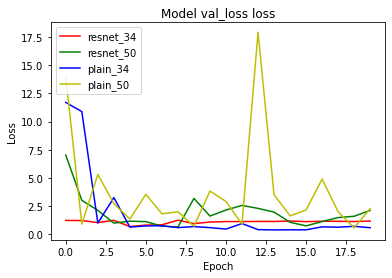

In [30]:
import matplotlib.pyplot as plt

plt.plot(his_resnet34.history['val_loss'], 'r')
plt.plot(his_resnet50.history['val_loss'], 'g')
plt.plot(his_plain_resnet34.history['val_loss'], 'b')
plt.plot(his_plain_resnet50.history['val_loss'], 'y')
plt.title('Model val_loss loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='upper left')
plt.show()

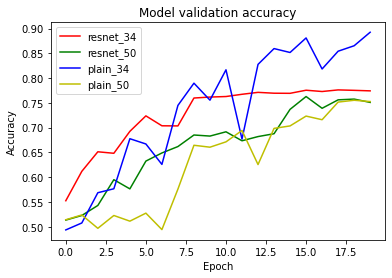

In [31]:
plt.plot(his_resnet34.history['val_accuracy'], 'r')
plt.plot(his_resnet50.history['val_accuracy'], 'g')
plt.plot(his_plain_resnet34.history['val_accuracy'], 'b')
plt.plot(his_plain_resnet50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='upper left')
plt.show()

#### 추가 실험
시간이 남으면 아래 카탈로그를 보고, `tensorflow-datasets`의 지원하는 다른 데이터셋에 실험을 해보자.

* [Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview)

### 회고
---
* 이론만 보던 ResNet을 직접 구현해보니, Residual Block이 더 와닿았다.
* 처음 직접 쌓아본 모델이었는데, 처음부터 끝까지 다할 수 있었다면 좋았겠지만, 구글링을 통해 baseline을 얻었다.
* 긴 시간동안 사투하면서 힘들었지만, 그래도 흥미를 느꼈다.

### 루브릭
---
* ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?<br>
(_블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다._)

    * __모델의 summary가 적절하게 출력되었다..__

* 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?.<br>
( _cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다_)
    
    * __모델학습을 진행하였고, loss값과 val_loss값의 감소 진행이 확인되었다.__

* Ablation Study 결과가 바른 포맷으로 제출되었는가?<br>
(_ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다._)
    
    * __residual 모델과 plain 모델의 accuracy를 비교해서 ablation study를 진행하였다.__